# Goal of analysis: classify product categories based on the product's description

- # Import necessary packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

import langid

[nltk_data] Downloading package punkt to /Users/benmurphy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
cat = pd.read_csv('categorization.csv')

ice_train = pd.read_csv('icecat.csv')

# We will merge the datasets together
ice_train = ice_train.merge(cat, how = 'inner', on = ['catid'])

# drop duplicate descriptions
ice_train = ice_train.drop_duplicates(['desc'])

ice_train.head(1)

,PK,catid,model_name,desc,category
0,445753,1406,Juice Extractor JE350,juice extractor quick easy juicing fruits vege...,juice makers


- # Data cleaning

In [3]:
ice_train['desc'][0]

'juice extractor quick easy juicing fruits vegetables apple carrot kiwi melon stainless steel permanent filter hard wearing easily removed cleaning generous litre removable pulp collector process apples compact space saving design safety lid interlock simple twist action ensures lid position machine operated cord storage prevents trailing flex work top two speed control hard soft fruit vegetables easy cleaning parts disassemble litres pint pulp colour wattage kenwood juice extractor green white kenwood juice extractor power colour product green white'

- Our descriptions are cuurently one long string.
- We must tokenize the descriptions. 
- We divide the sentence up into individual words.

In [4]:
ice_train['tokenized_desc'] = ice_train.apply(lambda row: word_tokenize(row['desc']), axis=1)
# print out first few words
ice_train['tokenized_desc'][0][0:5]

['juice', 'extractor', 'quick', 'easy', 'juicing']

- Check languages of descriptions

In [5]:
def detect_language(sentence):
    return langid.classify(sentence)[0]

ice_train['desc_lang'] = ice_train.apply(lambda row: detect_language(row['desc']), axis = 1)

print("Number of different languages: ", str(len(ice_train['desc_lang'].value_counts().index)))



Number of different languages:  56


Total number of samples: 19291
Total number of categories: 56
- 1 most frequent language: Count:17097, Language: en
- 2 most frequent language: Count:285, Language: it
- 3 most frequent language: Count:245, Language: fr


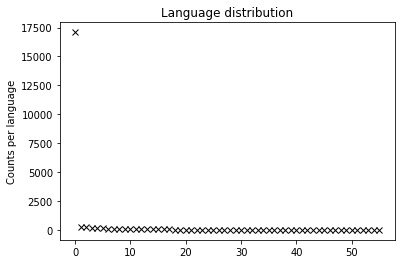

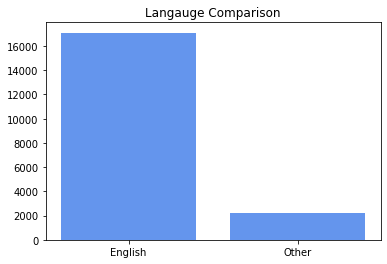

In [19]:
counts_per_lang = ice_train.desc_lang.value_counts()
plt.plot(np.arange(len(counts_per_lang)), counts_per_lang, 'xk')
plt.ylabel('Counts per language')
plt.title('Language distribution')

print("Total number of samples: {}".format(len(ice_train)))
print("Total number of categories: {}".format(len(counts_per_lang)))

for i in range(3):
    print("- {i} most frequent language: Count:{n}, Language: {name}".format(
            i=i+1,
            n = counts_per_lang.tolist()[i],
            name = counts_per_lang.index.tolist()[i]))
    
english_count = ice_train['desc_lang'].value_counts().iloc[:1].sum()
other_count = ice_train['desc_lang'].value_counts().iloc[1:].sum()
values = [english_count, other_count]

plt.figure(figsize=(6, 4))
plt.bar(x = ["English", "Other"], height = values, color = "cornflowerblue")
plt.title("Langauge Comparison")
plt.show()

- English is the clearly the most common language.
- We will only use the english descriptions from now on.

In [20]:
ice_train = ice_train.loc[ice_train["desc_lang"] == 'en']
ice_train.shape

(17097, 7)

- ## We are going to stem our words

In [21]:
ss_en = SnowballStemmer('english')

def stem_words(tokens):
    return [ss_en.stem(i) for i in tokens]
    
ice_train['tokenized_desc_stem'] = ice_train.apply(lambda row: stem_words(row['tokenized_desc']), axis = 1)

ice_train['tokenized_desc_stem'][0][0:5]

['juic', 'extractor', 'quick', 'easi', 'juic']

- We will convert our tokenized, stemmed descriptions back into strings for our vectorizer

In [22]:
def token_to_sentence(word_list):
    return ' '.join(word for word in word_list)

ice_train['desc_stem'] = ice_train.apply(lambda row: token_to_sentence(row['tokenized_desc_stem']), axis = 1)

# Lets take a look at our target: category

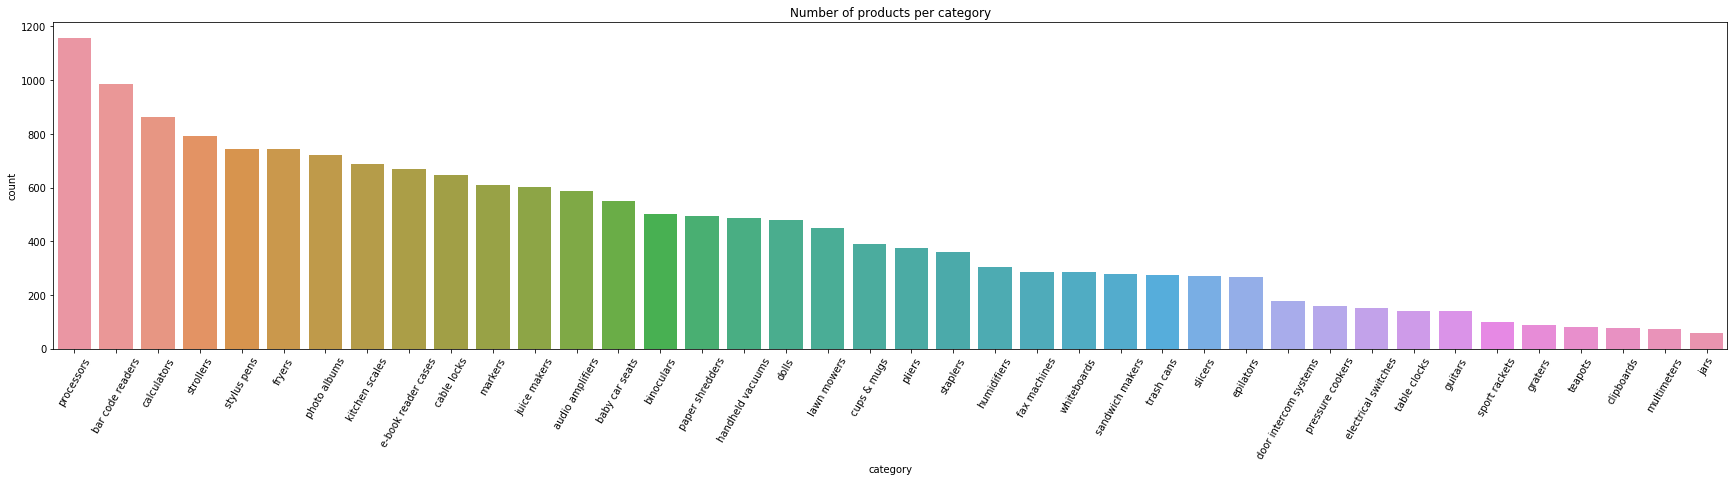

In [23]:
plt.figure(figsize=(30, 6))
plt.xticks(rotation=60)
sns.countplot(x="category", 
              data=ice_train, 
              order = ice_train['category'].value_counts().iloc[:].index
              ).set_title('Number of products per category')
plt.show()

- category is highly imbalanced, we will need to stratify our train and test sets later

# Vectorizer
- We will use the TFIDF vectorizer form sklearn 



In [27]:
text_data = ice_train['desc_stem']
text_data = np.array(text_data)

## And now testing TFIDF vectorizer:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_matrix[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 59 stored elements in Compressed Sparse Row format>

# Train and test sets preperation

In [28]:
# Mapping our category values from string to int

categories_dict = {'category': {'juice makers':0, 'processors':1, 'calculators':2, 'pliers':3,
       'photo albums':4, 'fax machines':5, 'e-book reader cases':6,
       'stylus pens':7, 'electrical switches':8, 'fryers':9, 'staplers':10,
       'door intercom systems':11, 'markers':12, 'dolls':13, 'paper shredders':14,
       'pressure cookers':15, 'whiteboards':16, 'trash cans':17, 'slicers':18, 'jars':19,
       'handheld vacuums':20, 'binoculars':21, 'table clocks':22, 'baby car seats':23,
       'cable locks':24, 'cups & mugs':25, 'graters':26, 'bar code readers':27,
       'audio amplifiers':28, 'lawn mowers':29, 'clipboards':30, 'kitchen scales':31,
       'strollers':32, 'epilators':33, 'guitars':34, 'humidifiers':35, 'teapots':36,
       'sandwich makers':37, 'multimeters':38, 'sport rackets':39}}

# Create a category name column to store the category name
ice_train['category_name'] = ice_train['category']

# Use our dictionary to replace categories in our datframe with numbers
ice_train.replace(categories_dict, inplace=True)

- We will create a dataframe using our vectorizer and feature names

In [29]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

df_cats = list(ice_train['category'])
tfidf_df['CATEGORY'] = df_cats

In [30]:
# Target Column
y = tfidf_df['CATEGORY']

# Features to use in model
X = tfidf_df.drop('CATEGORY', axis=1)

#Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=df_cats)

# ML model - logistic regression

In [31]:
start = time.time()

# solver=lbfgs https://en.wikipedia.org/wiki/Limited-memory_BFGS
log = LogR(solver='lbfgs')
log.fit(X_train, y_train)

end = time.time()
total = end-start
print('Training time: %s' % total)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training time: 138.32762122154236


In [32]:
train_pred = log.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print("Train accuracy: %s" % round(train_acc, 4))

test_pred = log.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print("Test accuracy: %s" % round(test_acc, 4))

Train accuracy: 0.9827
Test accuracy: 0.971


- Very good accuracy for our model
- No clear signs of overfitting as Train and Test accuracy are very similiar
- Training time is somewhat slow

## Dimensionality Reduction to improve performance of our model

In [ ]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=100, random_state=42)

svd_model.fit(tfidf_matrix.T)

len(svd_model.components_)

cols = np.arange(svd_model.components_.shape[0])
svd_df = pd.DataFrame(svd_model.components_.T, columns=cols)

svd_df['category_label'] = df_cats

In [ ]:
cols = np.arange(svd_model.components_.shape[0])
svd_df = pd.DataFrame(svd_model.components_.T, columns=cols)

In [ ]:
svd_df['category_label'] = df_cats
svd_df.shape